## Создание искусственных нейронных сетей

### Импорт собранных и обработанных данных

In [17]:
import pandas as pd

# Для mac
df_nlp = pd.read_csv(r'/Users/user/Documents/ML.csv')

# Для win
#df_nlp = pd.read_csv(r'C:\Users\User\Downloads\ML.csv'), если в начале лишних столбец с индексами

df_ml = df_nlp.drop(df_nlp.columns[[0,3,4,5,6,7,8,9,10]], axis = 1)

categories = {}
for key, value in enumerate(df_ml["main_rubric"].unique()):
    categories[value] = key + 1
df_ml['category_code'] = df_ml['main_rubric'].map(categories)

df_ml

,main_rubric,rubric,text_lemm,title_lemm,category_code
0,Происшествия,Происшествия,восемь человек погибать пострадать результат о...,тасс лнр время обстрел погибать восемь человек,1
1,Происшествия,Происшествия,буквально сегодня ночь вновь обстреливать мирн...,тасс обстрел всу лантратовка лнр погибать восе...,1
2,Происшествия,Происшествия,результате обстрел населенный пункт лантратовк...,результате обстрел всу лантратовка лнр погибат...,1
3,Происшествия,Происшествия,украинская армия наносить удар село лантратовк...,обстреле садиться лантратовка лнр украинский б...,1
4,Происшествия,Происшествия,результате обстрел украинский националист насе...,обстреле всу садиться лантратовка лнр погибать...,1
...,...,...,...,...,...
3428,Наука,Космос,китай суметь успешно осуществлять запуск первы...,китай потерять спутник запуск первый метановый...,9
3429,Наука,Космос,спутников который находиться борт ракета потеряны,старт первый мир ракета метан чжуцюэ заканчива...,9
3430,Наука,Космос,помимо испытание новый тип двигатель цель мисс...,первый орбитальный запуск ракета жидкий метан ...,9
3431,Наука,Космос,ходе миссия чжуцюэ удаваться достигать орбита ...,попытка запуск первый мир метановый орбитальны...,9


### Импорт необходимых библиотек

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#from sklearn.preprocessing import OneHotEncoder

### TensorFlow

In [10]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

# from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score

# from gensim.models import Word2Vec

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Input, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras import backend as K
# from keras.engine.topology import Layer

Количество уникальных тем:  9
3433
                                              text_lemm
2579  главный режиссер глазовский драматический теат...
3351  имеющимся данные первый ступень отрабатывать ш...
2800  кинематографисты часто уходить потусторонний м...
2802  декабре год выходить эпос лоуренс аравийский д...
2893   © dell отмечать dell пока luna  —  это лишь к...
...                                                 ...
1095  например центральный пляж обустраивать лаундж ...
1130  говорить заграничный направление новогодний пр...
1294  словам президент девять месяц год экспорт прод...
860   третья начало ноябрь православный святыня приб...
3174  среди обновление улучшать редактор статистика ...

[2403 rows x 1 columns]
                                              text_lemm
2469  российская исполнительница композитор песня ви...
3145  южнокорейская компания samsung продолжать быст...
1422  молдавия хотеть подавать газпром суд иметь воз...
2829  росатом смочь полноценный запускать св

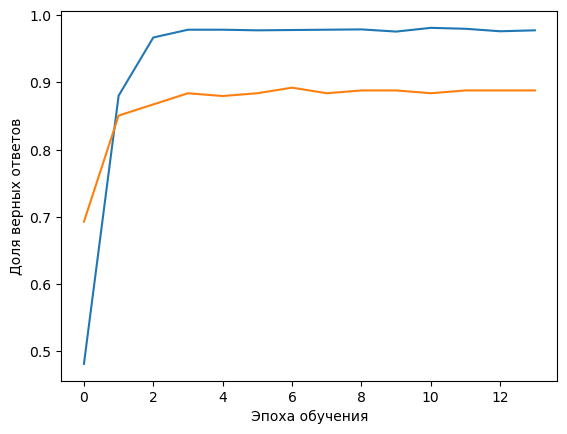

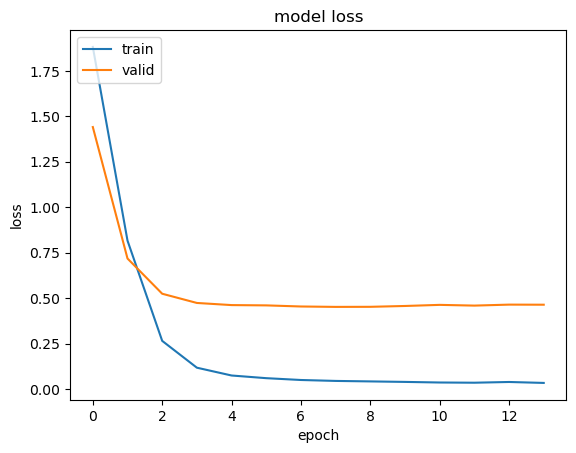

In [28]:
X = df_ml.loc[:, ['text_lemm']]
y = df_ml.loc[:, ['main_rubric','category_code']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

df = df_ml
print("Количество уникальных тем: ", len(df['main_rubric'].unique()))
print(len(df['text_lemm']))
#print(df['text_lemm'].tolist())


# Избавляемся от пустых строк
df = df[df['text_lemm'].notna()]

X_train = X_train[X_train.notna()]
X_test = X_test[X_test.notna()]
y_train = y_train[y_train.notna()]
y_test = y_test[y_test.notna()]

print(X_train)
print(X_test)
print(y_train)
print(y_test)


max_words = 0
for text in X_train['text_lemm']:
    words = len(text.split())
    if words > max_words:
        max_words = words
print('Максимальное количество слов в самом длинном описании заявки: {} слов'.format(max_words))


# Максимальное количество слов
num_words = 10000 #Можно менять

# Количество классов (тем)
rubrics = ['Политика', 'Общество', 'Экономика',
           'В мире', 'Спорт', 'Происшествия',
           'Культура', 'Технологии', 'Наука']

nb_classes = len(rubrics)

posts_train = X_train['text_lemm']
posts_test = X_test['text_lemm']

# Максимально количество слов в тексте
max_post_len = 35 #Можно менять

# Преобразуем классы в векторный вид
y_train = to_categorical(y_train['category_code'] - 1, nb_classes)
y_test = to_categorical(y_test['category_code'] - 1, nb_classes)

# Производим токенизацию текста
tokenizer = Tokenizer(num_words=num_words)  # 10000 самых встречаемых слов
#tokenizer = Tokenizer()

tokenizer.fit_on_texts(df_ml['text_lemm'].tolist())
print(len(tokenizer.index_word))
#num_words = len(tokenizer.index_word) - 1

# Слова в виде чисел
sequences_train = tokenizer.texts_to_sequences(posts_train.to_list())
sequences_test = tokenizer.texts_to_sequences(posts_test.to_list())

# Преобразуем векторы к одной длине путем добавления нулей
x_train = pad_sequences(sequences_train, maxlen=max_post_len)
x_test = pad_sequences(sequences_test, maxlen=max_post_len)

'''
word_index = tokenizer.word_index

tokens = []
for text in df_train['text_lemm']:
    token = text.split(' ')
    token = [tok for tok in token if tok != "" and tok != '\n']
    tokens.append(token)

df_train['tokens'] = tokens
data = df_train['tokens']
print(data)
w2v_model = Word2Vec(data, min_count=1, size=100, window=5)

embedding_index = dict()
for word in w2v_model.wv.vocab:
    embedding_index[word] = w2v_model.wv.word_vec(word)
print(embedding_index)


def prepare_matrix(embedding_dict, emb_size=100):
    num_words = len(word_index)
    embedding_matrix = np.zeros((num_words, emb_size))

    for word, i in tqdm(word_index.items()):
        if i >= num_words:
            continue

        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec
    return embedding_matrix


embedding_matrix = prepare_matrix(embedding_index)
num_words = len(word_index)
'''


def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results


x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)
# print(x_train)

#print(x_train)
#print(tokenizer.word_index)
#print(len(x_train))

#smote = SMOTE(sampling_strategy='auto',
#              random_state=0,
#              k_neighbors=4)
#X_train, y_train = smote.fit_resample(x_train, y_train)
#X_test, y_test = smote.fit_resample(x_test, y_test)
#print(len(X_sm))
#print(len(X_train))

# Сеть LSTM ############################################################

model = Sequential()

'''
model.add(Embedding(num_words, 256, input_length=max_post_len))
model.add(Dropout(0.5))
model.add(GRU(256))
model.add(Dropout(0.5))
model.add(Dense(207, activation='softmax'))
'''
'''
model.add(Embedding(num_words, 256, input_length=max_post_len))
model.add(Dropout(0.5))
model.add(LSTM(256, recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(210, activation='softmax'))
'''

model.add(Dense(256, activation='relu', input_shape=(10000,))) #Можно менять dense 256
model.add(Dropout(0.2)) #Можно менять Dropout
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(207, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))
model.summary()


'''
model.add(Embedding(num_words, 202, input_length=max_post_len))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(207, activation='softmax'))
'''
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.load_weights('model1.h5')
model_save_path = 'model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

history = model.fit(x_train,
                    y_train,
                    epochs=14, #Можно менять
                    batch_size=64, #Можно менять
                    validation_split=0.1, #Можно менять
                    callbacks=[checkpoint_callback])

score = model.evaluate(x_test, y_test, batch_size=128, verbose=1)

print()
print("Оценка теста: {}".format(score[0]))
print("Оценка точности модели: {}".format(score[1]))


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
#plt.legend()
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
